## ConvAE Results

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import nibabel as nib
import time
import sys

sys.path.append('/home/agajan/DeepMRI')
from deepmri.Datasets import Volume3dDataset
import deepmri.utils as utils
from DiffusionMRI.OldConvEncoder import ConvEncoder
from DiffusionMRI.OldConvDecoder import ConvDecoder

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


In [3]:
mu = 307.3646240234375
std = 763.4876098632812
batch_size = 10

data_path = '/media/schultz/345de007-c698-4c33-93c1-3964b99c5df6/agajan/experiment_DiffusionMRI/'
validset = Volume3dDataset(data_path + 'data/one_data/', mu=mu, std=std, sort=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=10)

print("Total examples: ", len(validset))

Total examples:  10


In [4]:
conv_encoder = ConvEncoder(input_channels=1)
conv_decoder = ConvDecoder(out_channels=1)

# send models to device
conv_encoder.to(device)
conv_decoder.to(device)

# load pretrained weights
epoch = 21
print("Loading weights after training for {} epochs".format(epoch))
conv_encoder_path = '/home/agajan/DeepMRI/DiffusionMRI/models/conv_encoder_epoch_' + str(epoch)
conv_decoder_path = '/home/agajan/DeepMRI/DiffusionMRI/models/conv_decoder_epoch_' + str(epoch)
conv_encoder.load_state_dict(torch.load(conv_encoder_path))
conv_decoder.load_state_dict(torch.load(conv_decoder_path))

# count parameters
p1 = utils.count_model_parameters(conv_encoder)
p2 = utils.count_model_parameters(conv_decoder)
print("Total parameters: {}, trainable parameters: {}".format(p1[0] + p2[0], p1[1] + p2[1]))

Loading weights after training for 21 epochs
Total parameters: 139587, trainable parameters: 139587


In [5]:
# evaluate
conv_encoder.eval()
conv_decoder.eval()

criterion = nn.MSELoss()

conv_recons = []

with torch.no_grad():
    running_loss = 0.0
    epoch_start = time.time()
    
    for data in validloader:
        x = data.to(device)
        x_out = conv_decoder(conv_encoder(x))
        
        loss = criterion(x, x_out)
        running_loss = running_loss + loss.item() * data.size(0)
    
    epoch_loss = running_loss / len(validset)
    print("Loss: {}, inference time: {:.5f} seconds".format(epoch_loss, time.time() - epoch_start))

Loss: 0.02426747977733612, inference time: 0.85811 seconds


## Visualize Reconstructions from Learned Features

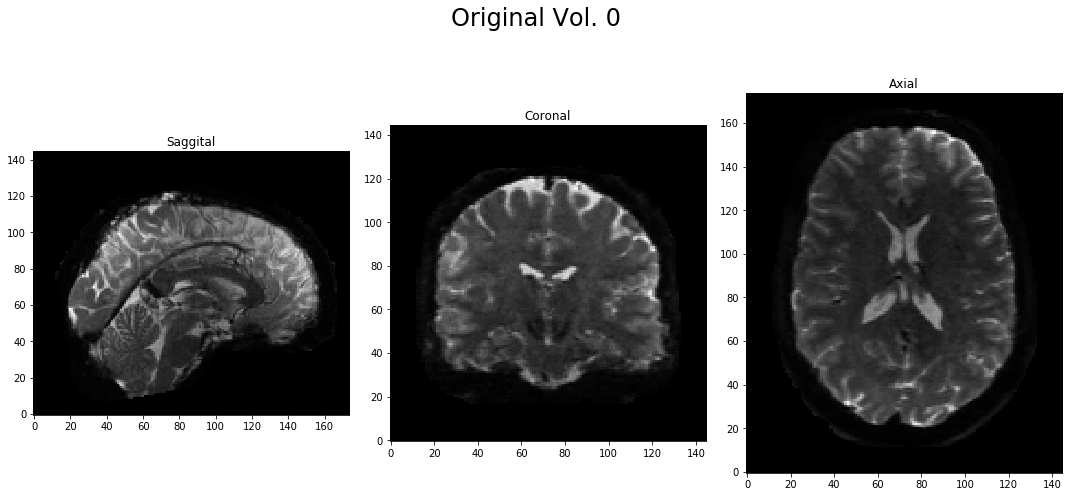

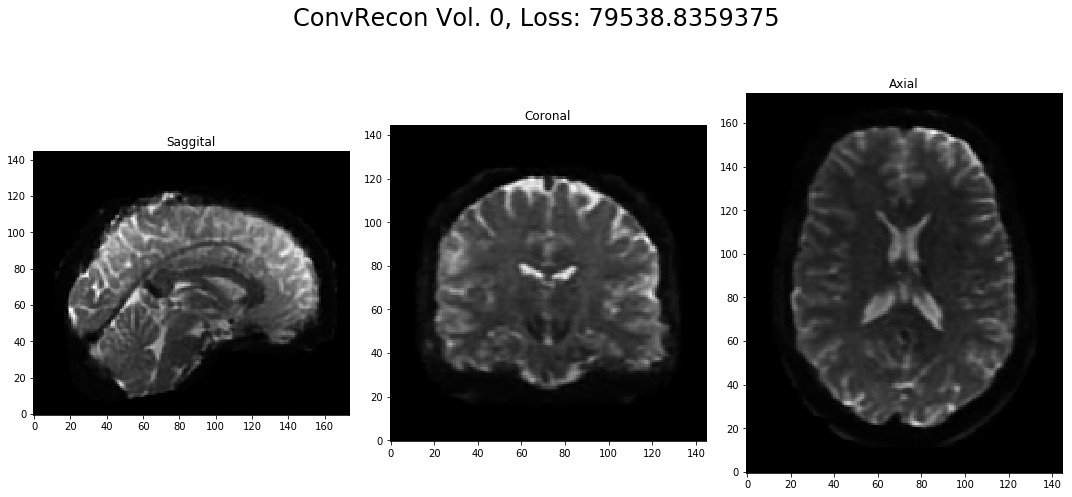

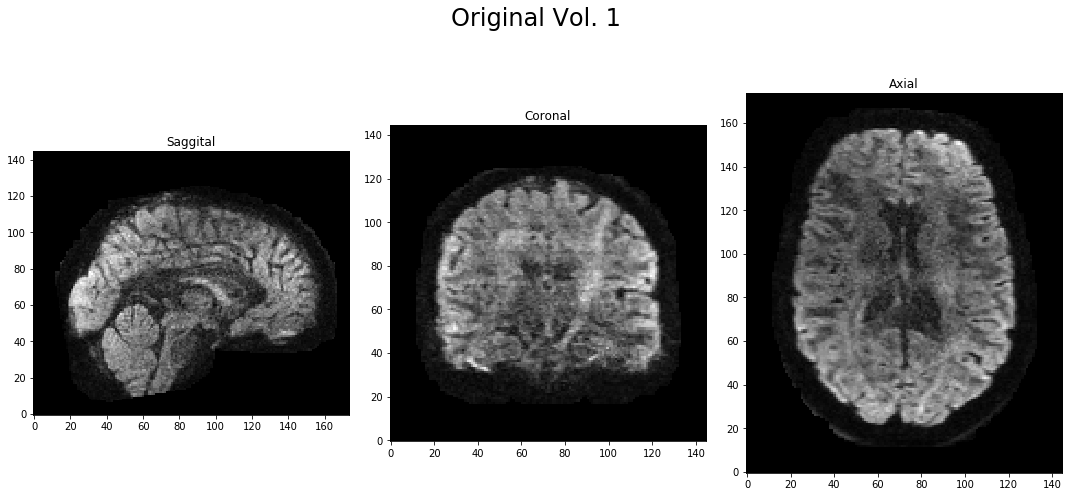

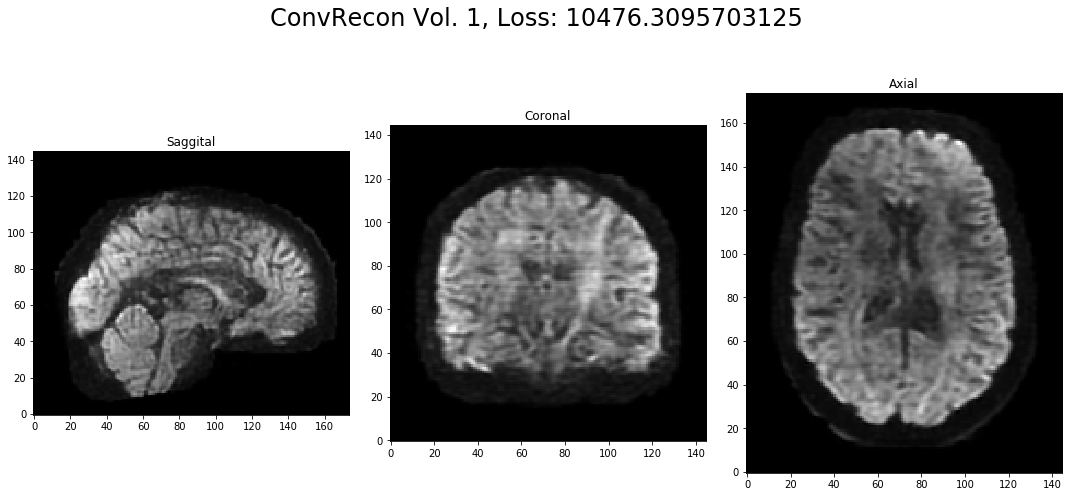

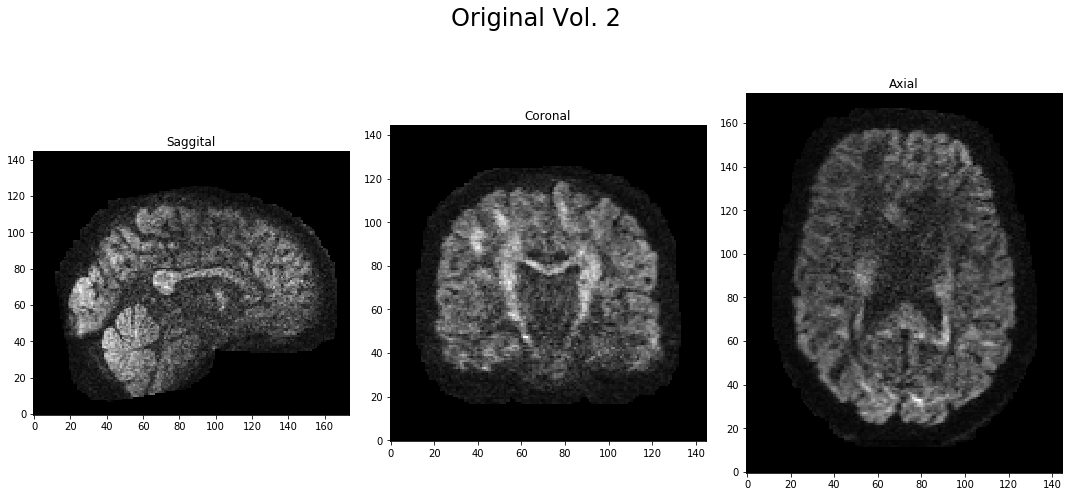

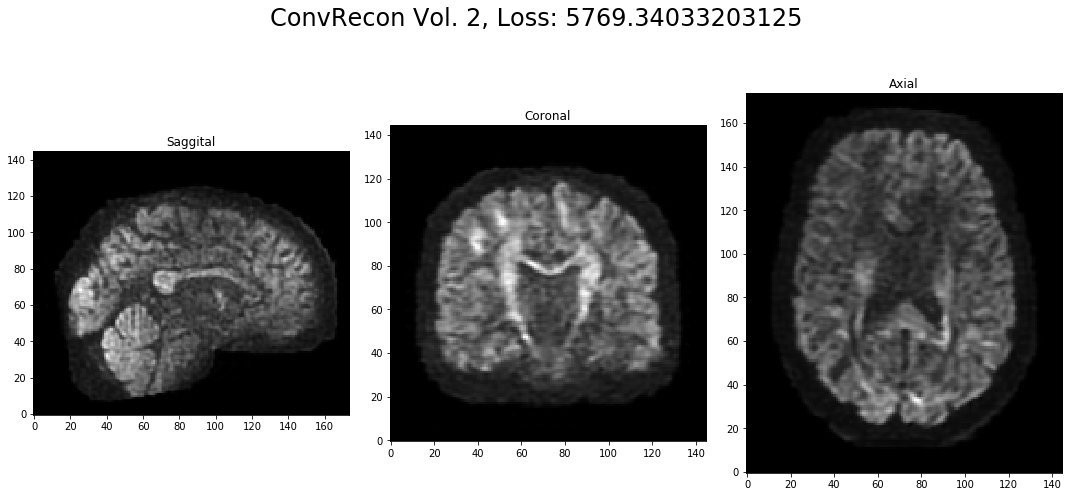

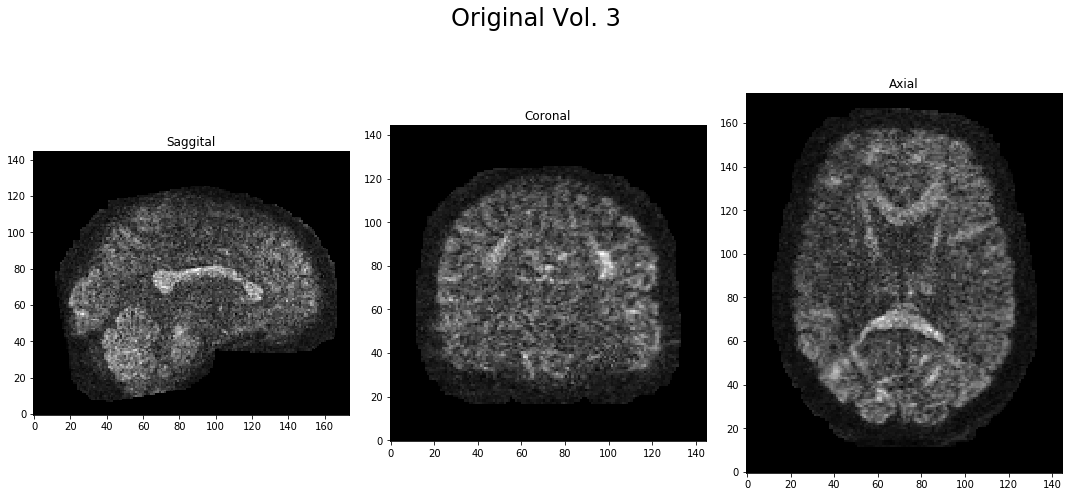

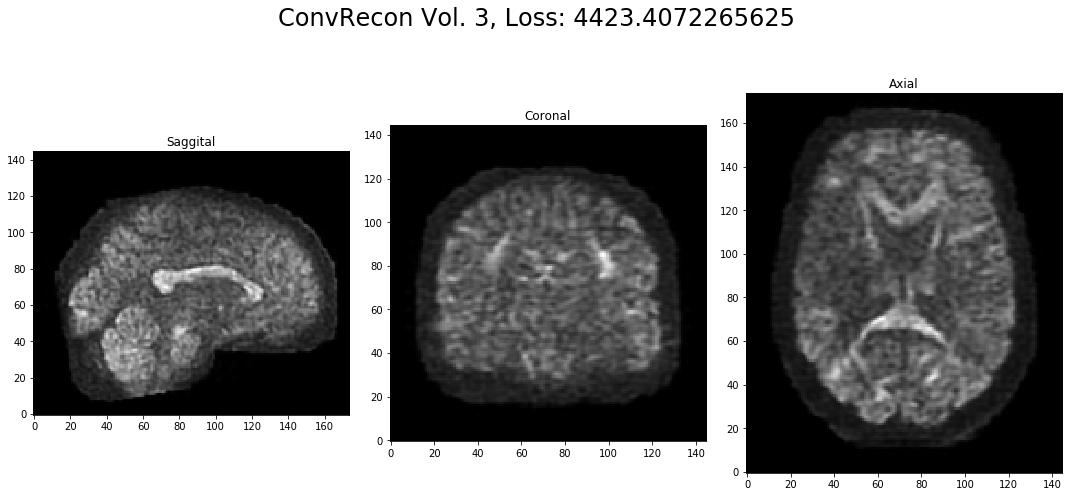

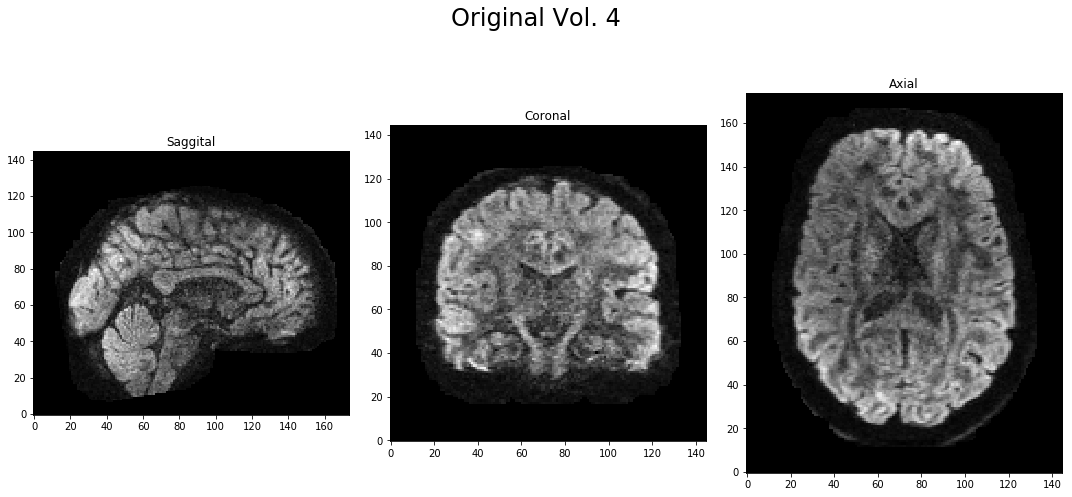

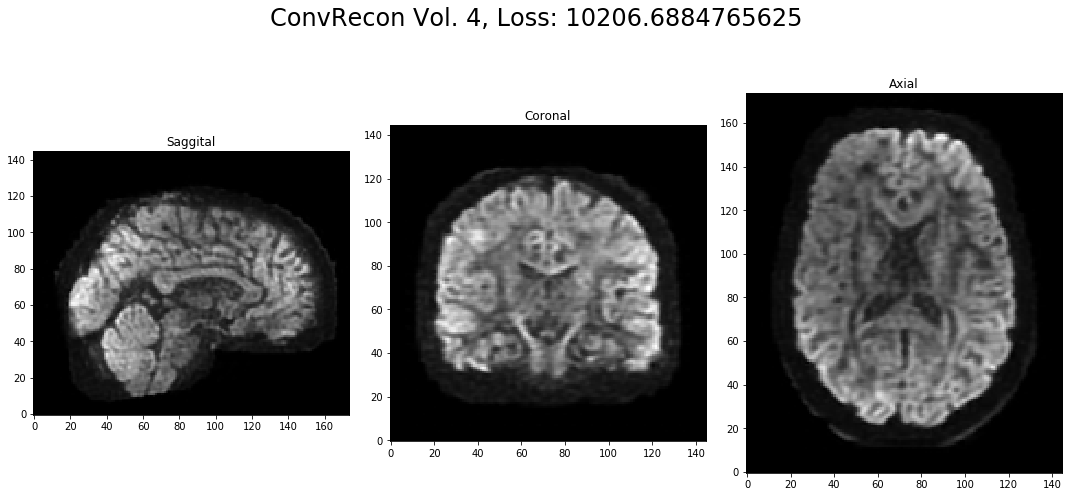

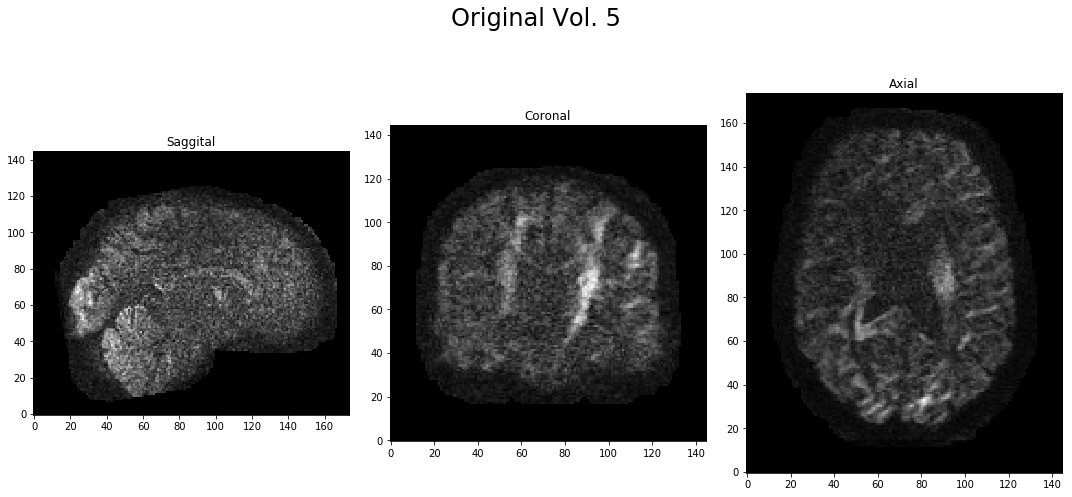

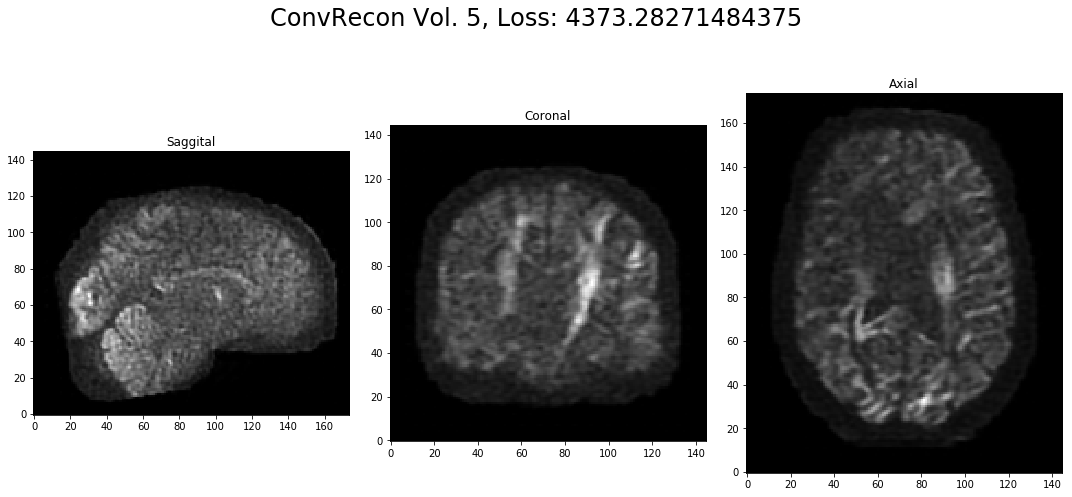

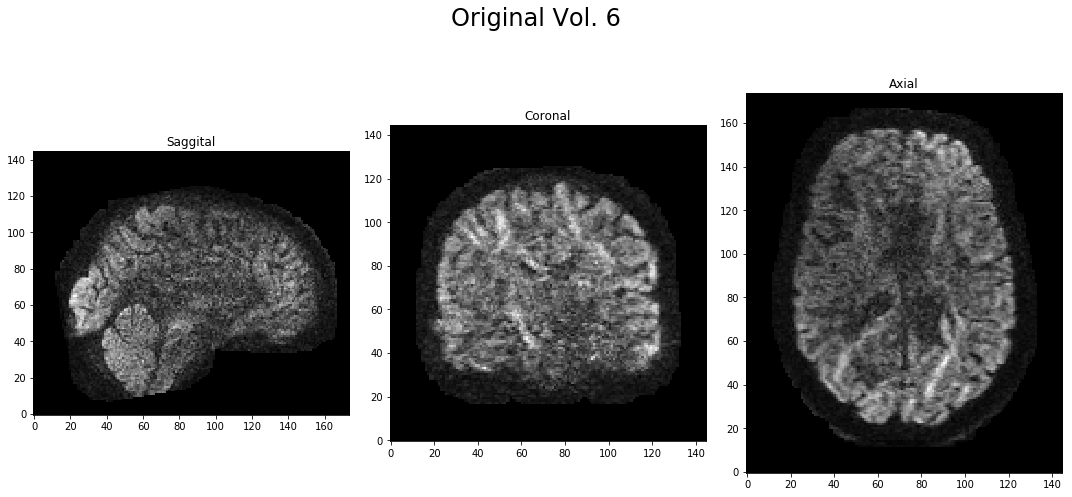

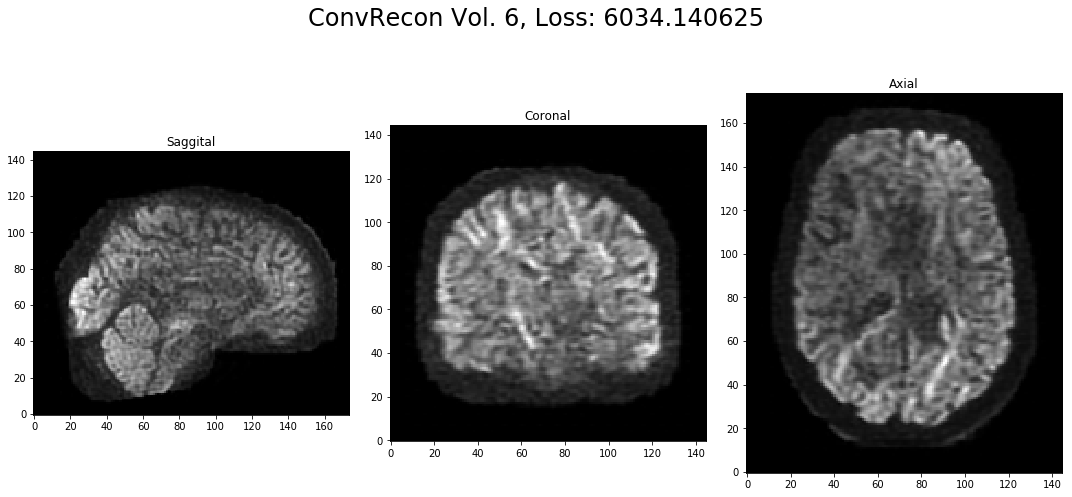

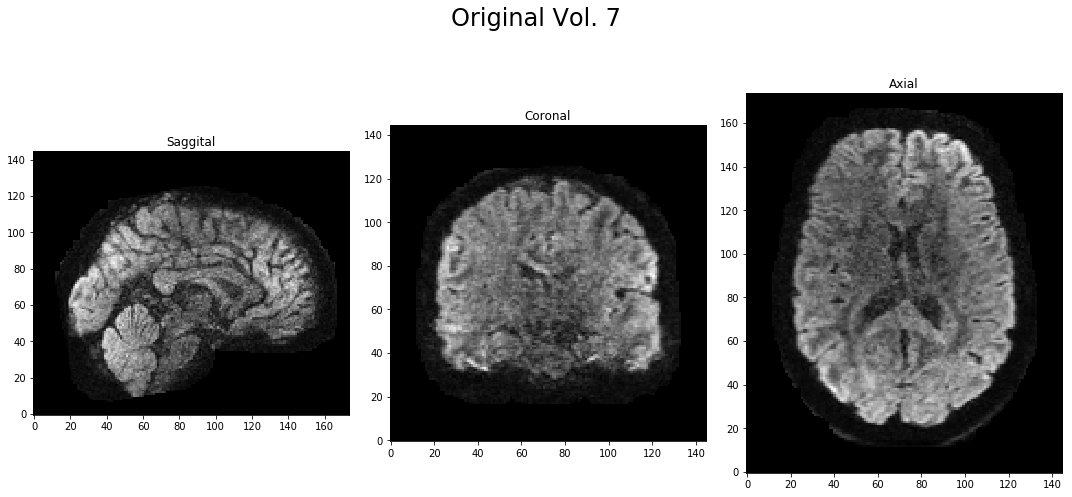

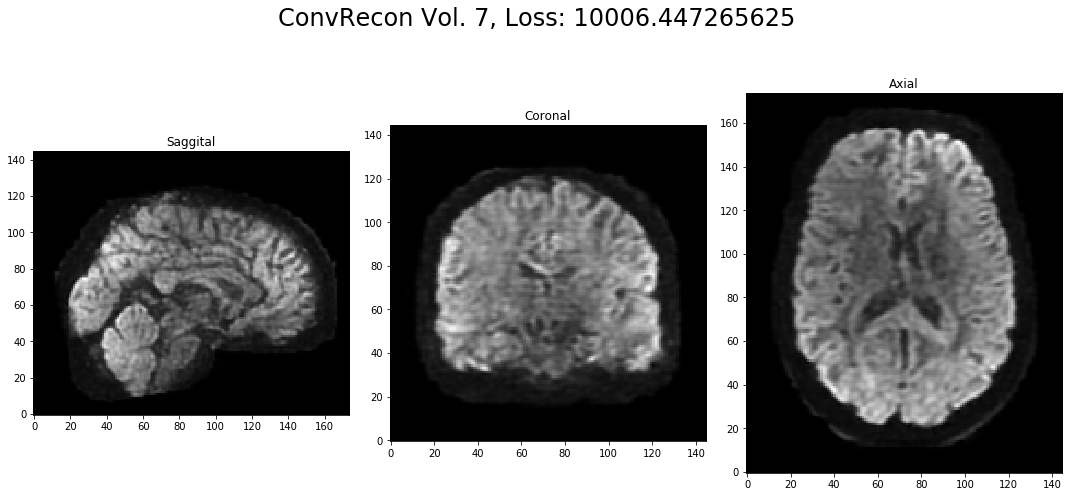

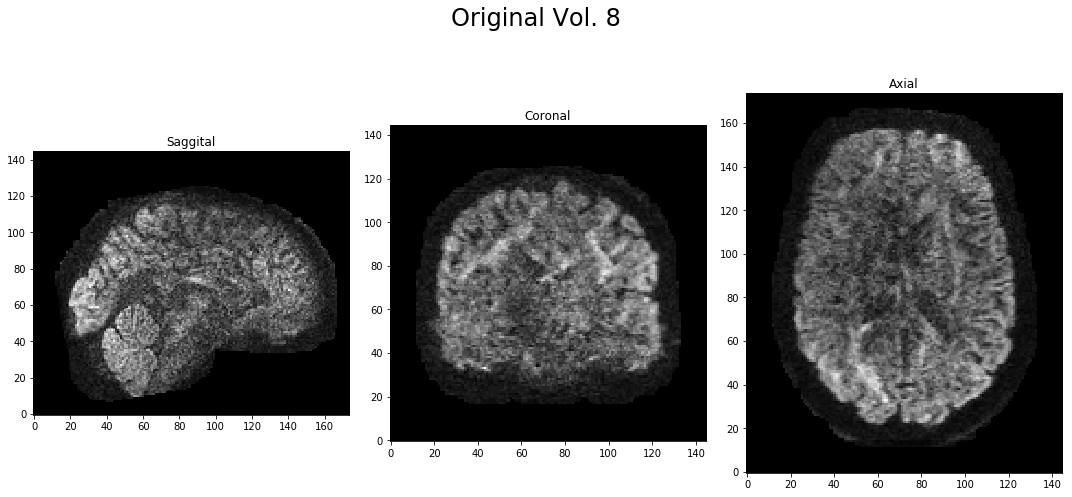

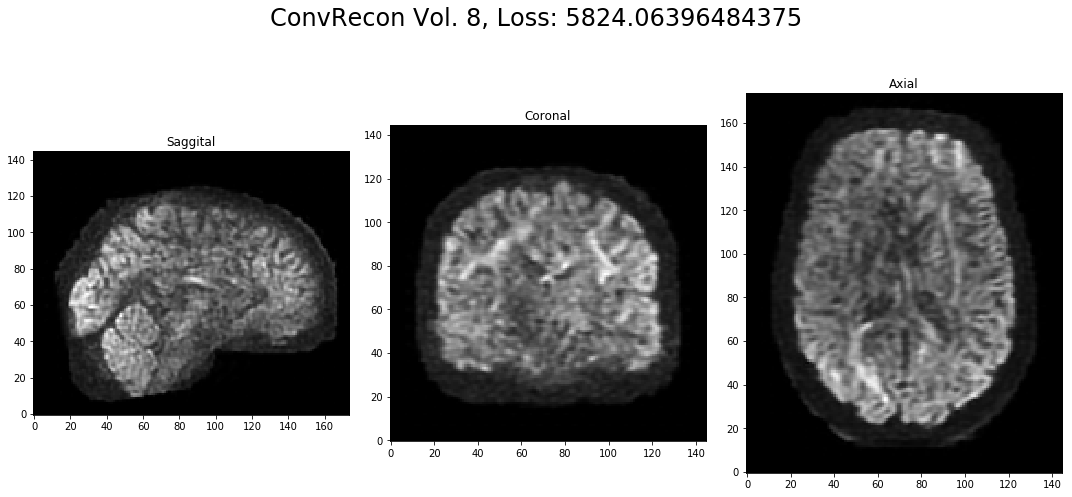

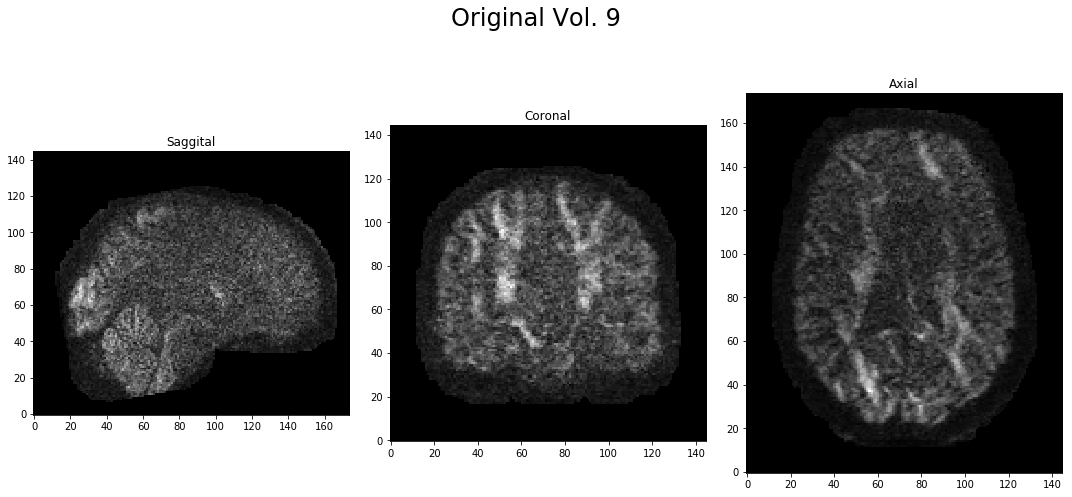

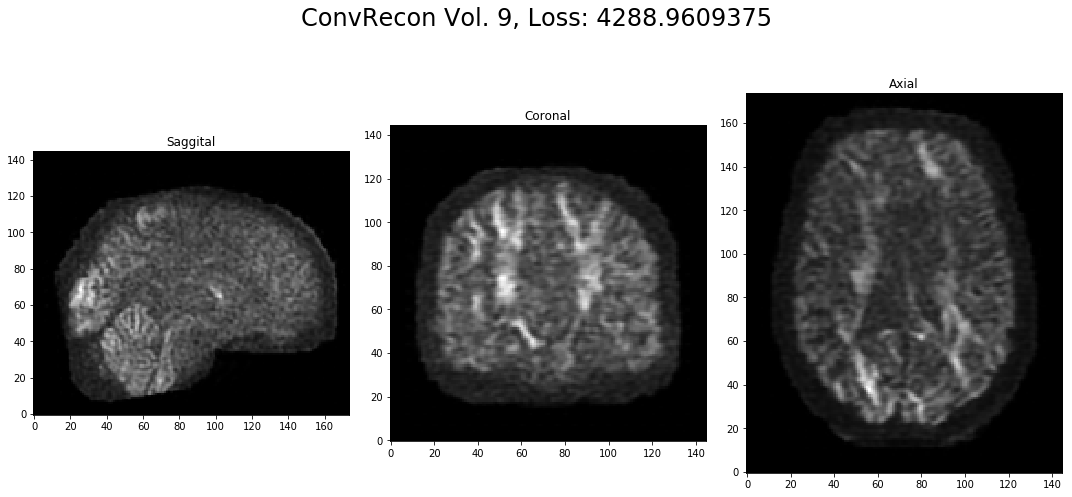

In [6]:
seq_len = 10

x_coord = 72
y_coord = 87
z_coord = 72

data = (data * std + mu).clamp(min=0).cpu()
conv_recons = (x_out * std + mu).clamp(min=0).cpu()

for vol_idx in range(seq_len):
    orig = data.squeeze()[vol_idx]
    conv_recon = conv_recons.squeeze()[vol_idx]
    
    conv_vol_loss = criterion(orig, conv_recon).item()
    
    utils.show_slices([
        orig[x_coord, :, :].numpy(),
        orig[:, y_coord, :].numpy(),
        orig[:, :, z_coord].numpy(),
    ], figsize=(15, 8), suptitle="Original Vol. {}".format(vol_idx))
    
    utils.show_slices([
        conv_recon[x_coord, :, :].numpy(),
        conv_recon[:, y_coord, :].numpy(),
        conv_recon[:, :, z_coord].numpy(),
    ], figsize=(15, 8), suptitle="ConvRecon Vol. {}, Loss: {}".format(vol_idx, conv_vol_loss))